- ResNet 기본 구조
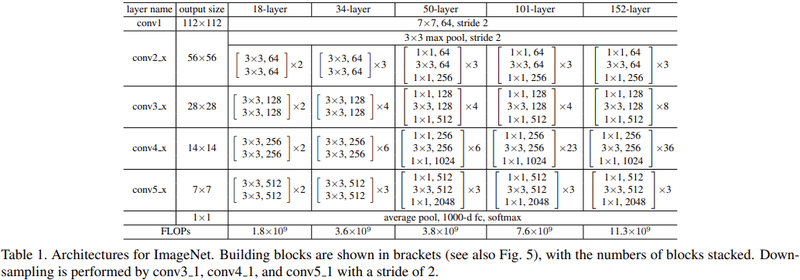

- 루브릭
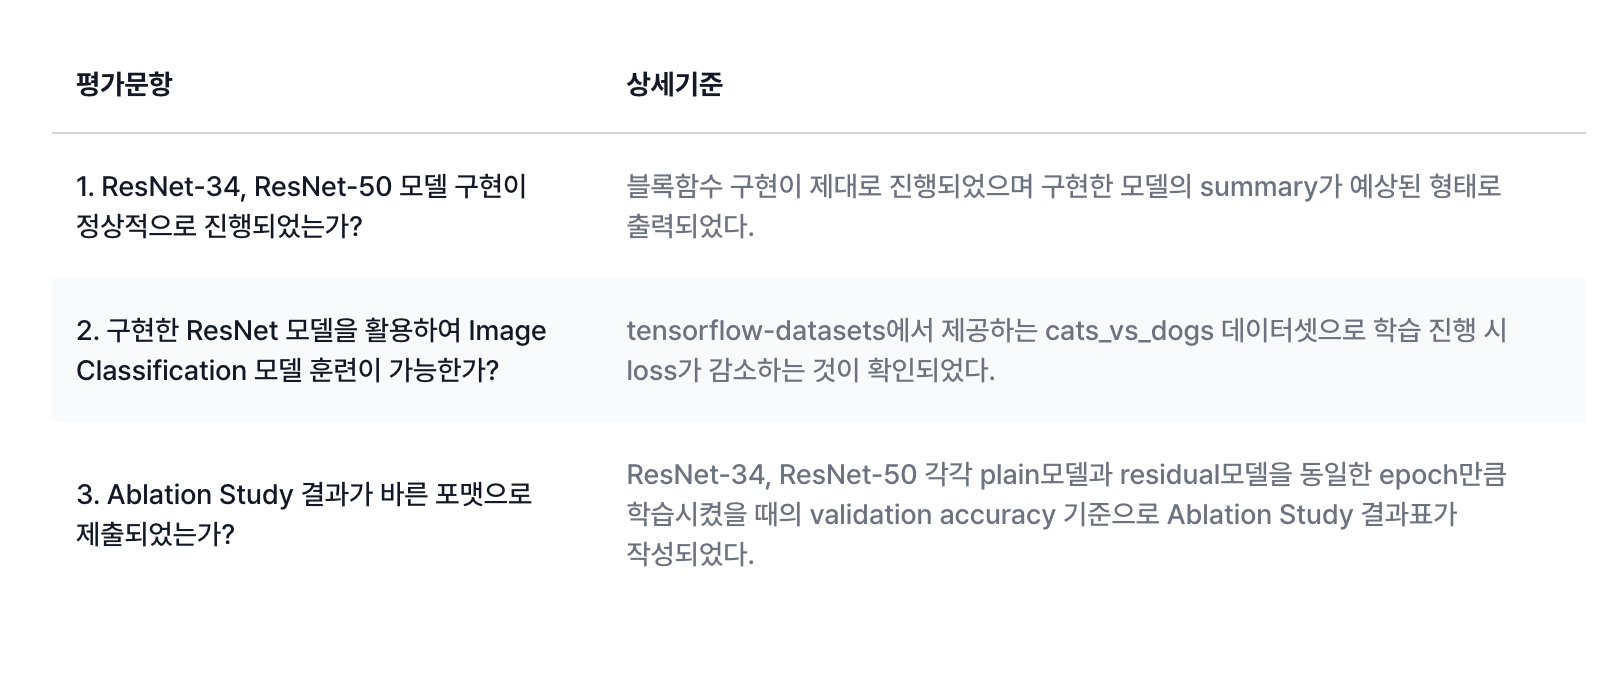

1. 데이터 수집 및 전처리
- tensorflow_datasets에 있는 cifar10 데이터 가져오기
- 데이터 사이즈 정규화 처리

2. 모듈형 함수 만들기
- build_conv_block: 블록 생성을 위한 함수
- build_resnet: resnet 모델 생성을 위한 함수
- build_plainnet: plainnet 모델 생성을 위한 함수

3. 모델 생성
- ResNet34
- ResNet50
- Plainnet34
- Plainnet50

4. 모델 훈련 및 검증 
- 사용자 정의 
- 각 모델 별 컴파일 및 fit 진행

5. 훈련 및 검증 지표 시각화
- 시각화를 통한 모델 성능 비교

1. 데이터 수집 및 전처리

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [6]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(ds):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(ds['image'], tf.float32) / 255, ds['label']

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# 파라미터 세팅

BATCH_SIZE = 256
EPOCH = 15

In [9]:
# 데이터셋 로딩 및 전처리 파이프라인
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

2. 모듈형 함수 만들기

In [10]:
# function for building ResNet conv Block

def build_conv_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_same_layer=True,
                    is_pooling=False,
                    is_plainnet=True
                   ):
    """
    ResNet 블럭 구성 함수
    input_layer: 입력 레이어
    num_cnn: cnn 레이어의 개수
    channel: 블록 내에서의 채널 개수
    block_num: 블록 번호
    is_same_layer: 기본 레지듀얼 블록인지 여부
    is_pooling: 첫 번째 레이어에서 스트라이드 2 적용 여부
    is_plainnet: 스킵 연결 여부
    """
    # 입력 레이어
    x = input_layer
    
    if is_pooling:
        stride=2
    else:
        stride=1

    # CNN 레이어
    for cnn_num in range(num_cnn):
        identity = x
        # 기본 resnet 블록일 경우
        if is_same_layer:
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)
            x = keras.layers.BatchNormalization()(x) # 정규화
            x = keras.layers.ReLU()(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)
            channel_size = channel
        else:  # Bottleneck ResNet 블록
            x = keras.layers.Conv2D(
                filters=channel, kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x) # 정규화
            x = keras.layers.ReLU()(x)
            
            x = keras.layers.Conv2D(
                filters=channel, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x) # 정규화
            x = keras.layers.ReLU()(x)
            
            x = keras.layers.Conv2D(
                filters=channel*4, kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(x)        
            channel_size = channel*4
    x = keras.layers.BatchNormalization(name=f'conv{block_num}_x')(x)
    
    # Skip connection (Identity)
    if is_plainnet:
        return x
    else:
        if identity.shape[-1] != x.shape[-1]:  # 채널 수가 맞지 않으면 일치시킴
            identity = keras.layers.Conv2D(
                filters=x.shape[-1], kernel_size=(1, 1), strides=stride, padding='same'
            )(identity)
            identity = keras.layers.BatchNormalization()(identity)

        x = keras.layers.Add()([x, identity])
        x = keras.layers.ReLU()(x)
    return x

In [25]:
conv_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
conv_block_output = build_conv_block(conv_input_layer, is_pooling=True)    # conv 블록 생성

In [26]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=conv_input_layer, outputs=conv_block_output)  
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_72 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu_54 (ReLU)              (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_73 (Batc (None, 32, 32, 64)        256 

In [11]:
# ResNet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10,
                is_50=True
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # conv1_x: 7X7, 64, stride 2
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='conv1'
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.ReLU()(output)
 
    # conv2_x MaxPooling
    output = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(output)
    
    # conv2_x ~ conv5_x: config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_conv_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i+2,
            is_same_layer=True if not is_50 else False,
            is_pooling=True if i > 0 else False,  # conv2_x 이후부터 풀링 적용
            is_plainnet=False
        )
        
    # Average Pooling 레이어      
    output = keras.layers.AveragePooling2D(pool_size=(2, 2), padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [12]:
# Plainnet 모델 자체를 생성하는 함수입니다.
def build_plainnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10,
                is_50=True
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # conv1_x: 7X7, 64, stride 2
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='conv1'
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.ReLU()(output)
 
    # conv2_x MaxPooling
    output = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(output)
    
    # conv2_x ~ conv5_x: config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_conv_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i+2,
            is_same_layer=True if not is_50 else False,
            is_pooling=True if i > 0 else False,  # conv2_x 이후부터 풀링 적용
            is_plainnet=True
        )
        
    # Average Pooling 레이어      
    output = keras.layers.AveragePooling2D(pool_size=(2, 2), padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

3. 모델 생성

In [13]:
# 기본값을 그대로 사용해서 ResNet 모델을 만들면 ResNet_34이 됩니다.
resnet_34 = build_resnet(is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
# 파라미터를 수정해서 ResNet-50 만들기
resnet_50 = build_resnet(is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu_21 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [20]:
# 파라미터를 수정해서 PlainNet-34 만들기
plain_34 = build_plainnet(is_50=False)
plain_34.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_83 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_91 (ReLU)              (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_84 (Batc (None, 8, 8, 64)          256 

In [15]:
# 파라미터를 수정해서 PlainNet-50 만들기
plain_50 = build_plainnet(is_50=True)
plain_50.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_50 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_58 (ReLU)              (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_51 (Batc (None, 8, 8, 64)          256 

3. 모델 훈련 및 검증

In [17]:
# 사용자 콜백 정의
class CustomHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomHistory, self).__init__()
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        self.training_losses.append(logs.get('loss'))
        self.training_accuracies.append(logs.get('accuracy'))

    def on_epoch_end(self, epoch, logs=None):
        self.validation_losses.append(logs.get('val_loss'))
        self.validation_accuracies.append(logs.get('val_accuracy'))
        
        
# 사용자 정의 콜백 생성
history = CustomHistory()

In [18]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_r34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[history]
)

Epoch 1/15
195/195 [==============================] - 59s 261ms/step - loss: 2.4572 - accuracy: 0.1388 - val_loss: 2.3025 - val_accuracy: 0.1018
Epoch 2/15
195/195 [==============================] - 49s 253ms/step - loss: 2.4362 - accuracy: 0.1455 - val_loss: 2.3037 - val_accuracy: 0.1056
Epoch 3/15
195/195 [==============================] - 49s 254ms/step - loss: 2.4122 - accuracy: 0.1469 - val_loss: 2.3253 - val_accuracy: 0.1237
Epoch 4/15
195/195 [==============================] - 50s 254ms/step - loss: 2.3967 - accuracy: 0.1478 - val_loss: 2.4500 - val_accuracy: 0.1333
Epoch 5/15
195/195 [==============================] - 50s 255ms/step - loss: 2.3847 - accuracy: 0.1487 - val_loss: 2.4628 - val_accuracy: 0.1462
Epoch 6/15
195/195 [==============================] - 50s 254ms/step - loss: 2.3770 - accuracy: 0.1480 - val_loss: 2.4097 - val_accuracy: 0.1446
Epoch 7/15
195/195 [==============================] - 50s 254ms/step - loss: 2.3588 - accuracy: 0.1476 - val_loss: 2.4000 - val_ac

In [21]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[history]
)

Epoch 1/15
195/195 [==============================] - 58s 257ms/step - loss: 2.3876 - accuracy: 0.1293 - val_loss: 2.3112 - val_accuracy: 0.0947
Epoch 2/15
195/195 [==============================] - 49s 252ms/step - loss: 2.3713 - accuracy: 0.1317 - val_loss: 2.4120 - val_accuracy: 0.0989
Epoch 3/15
195/195 [==============================] - 49s 253ms/step - loss: 2.3641 - accuracy: 0.1286 - val_loss: 2.3172 - val_accuracy: 0.1254
Epoch 4/15
195/195 [==============================] - 50s 254ms/step - loss: 2.3609 - accuracy: 0.1260 - val_loss: 2.3495 - val_accuracy: 0.1354
Epoch 5/15
195/195 [==============================] - 50s 254ms/step - loss: 2.3580 - accuracy: 0.1271 - val_loss: 2.4024 - val_accuracy: 0.1279
Epoch 6/15
195/195 [==============================] - 49s 254ms/step - loss: 2.3494 - accuracy: 0.1262 - val_loss: 2.3717 - val_accuracy: 0.1328
Epoch 7/15
195/195 [==============================] - 49s 253ms/step - loss: 2.3387 - accuracy: 0.1286 - val_loss: 2.3487 - val_ac

In [44]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_r50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[history]
)

Epoch 1/15
195/195 [==============================] - 125s 574ms/step - loss: 2.5304 - accuracy: 0.1363 - val_loss: 2.3029 - val_accuracy: 0.1010
Epoch 2/15
195/195 [==============================] - 110s 563ms/step - loss: 2.5202 - accuracy: 0.1378 - val_loss: 2.3038 - val_accuracy: 0.1002
Epoch 3/15
195/195 [==============================] - 110s 565ms/step - loss: 2.5098 - accuracy: 0.1388 - val_loss: 2.3176 - val_accuracy: 0.1163
Epoch 4/15
195/195 [==============================] - 110s 566ms/step - loss: 2.4984 - accuracy: 0.1399 - val_loss: 2.3972 - val_accuracy: 0.1281
Epoch 5/15
195/195 [==============================] - 110s 567ms/step - loss: 2.4913 - accuracy: 0.1387 - val_loss: 2.5282 - val_accuracy: 0.1459
Epoch 6/15
195/195 [==============================] - 111s 568ms/step - loss: 2.4715 - accuracy: 0.1454 - val_loss: 2.5742 - val_accuracy: 0.1452
Epoch 7/15
195/195 [==============================] - 111s 567ms/step - loss: 2.4736 - accuracy: 0.1420 - val_loss: 2.4492 -

In [46]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[history]
)

Epoch 1/15
195/195 [==============================] - 119s 561ms/step - loss: 2.4069 - accuracy: 0.1327 - val_loss: 2.3322 - val_accuracy: 0.1001
Epoch 2/15
195/195 [==============================] - 109s 558ms/step - loss: 2.3992 - accuracy: 0.1321 - val_loss: 2.3332 - val_accuracy: 0.1040
Epoch 3/15
195/195 [==============================] - 109s 559ms/step - loss: 2.3934 - accuracy: 0.1350 - val_loss: 2.3337 - val_accuracy: 0.1218
Epoch 4/15
195/195 [==============================] - 110s 563ms/step - loss: 2.3879 - accuracy: 0.1351 - val_loss: 2.4759 - val_accuracy: 0.1306
Epoch 5/15
195/195 [==============================] - 110s 563ms/step - loss: 2.3796 - accuracy: 0.1341 - val_loss: 2.4423 - val_accuracy: 0.1013
Epoch 6/15
195/195 [==============================] - 110s 562ms/step - loss: 2.3676 - accuracy: 0.1388 - val_loss: 2.4596 - val_accuracy: 0.1099
Epoch 7/15
195/195 [==============================] - 109s 561ms/step - loss: 2.3621 - accuracy: 0.1358 - val_loss: 2.3972 -

5. 훈련 및 검증 지표 시각화 

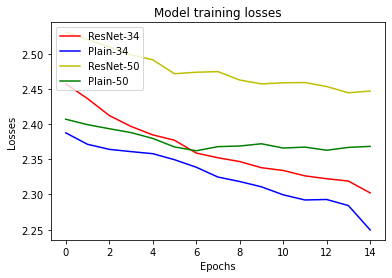

In [48]:
import matplotlib.pyplot as plt

# 학습 데이터 loss 비교
plt.plot(history_r34.history['loss'], 'r')
plt.plot(history_p34.history['loss'], 'b')
plt.plot(history_r50.history['loss'], 'y')
plt.plot(history_p50.history['loss'], 'g')
plt.title('Model training losses')
plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.legend(['ResNet-34', 'Plain-34', 'ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

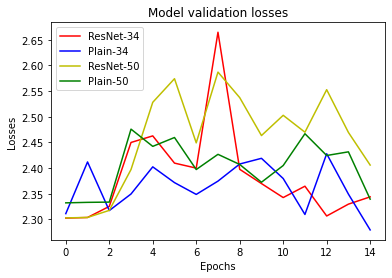

In [50]:
# 검증 데이터 loss 비교
plt.plot(history_r34.history['val_loss'], 'r')
plt.plot(history_p34.history['val_loss'], 'b')
plt.plot(history_r50.history['val_loss'], 'y')
plt.plot(history_p50.history['val_loss'], 'g')
plt.title('Model validation losses')
plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.legend(['ResNet-34', 'Plain-34', 'ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

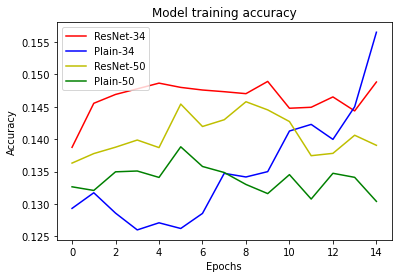

In [53]:
# 검증  데이터 accuracy 비교
plt.plot(history_r34.history['accuracy'], 'r')
plt.plot(history_p34.history['accuracy'], 'b')
plt.plot(history_r50.history['accuracy'], 'y')
plt.plot(history_p50.history['accuracy'], 'g')
plt.title('Model training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['ResNet-34', 'Plain-34', 'ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

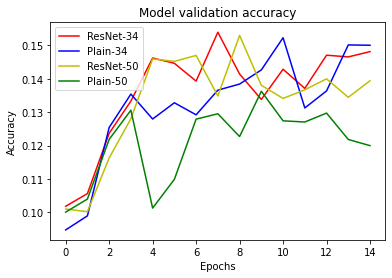

In [54]:
# 검증정확도 비교
plt.plot(history_r34.history['val_accuracy'], 'r')
plt.plot(history_p34.history['val_accuracy'], 'b')
plt.plot(history_r50.history['val_accuracy'], 'y')
plt.plot(history_p50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['ResNet-34', 'Plain-34', 'ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

6. 회고

In [ ]:
- 모델 성능이 이상한 걸로 봐서는 뭔가 제대로 구현이 되지 않은 것 같음
- Iteration 별로 시각화를 하고 싶었는데 마치지 못함
